## Image classification with Convolutional Neural Networks

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "../data/idcard3/dataset/"
sz=224
#sz=300
bs=64

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## reutilisons notre entrainement

In [7]:
arch=resnet34

In [44]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [45]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.precompute=False

In [46]:
learn.load('masterclass-iteration04')

Our ResNet model had Relu → BatchNorm. TorchVision does BatchNorm →Relu. There are three different versions of ResNet floating around, and the best one is PreAct (https://arxiv.org/pdf/1603.05027.pdf).
- Currently, the final layer has a thousands features because ImageNet has 1000 features, so we need to get rid of it.
- When you use fast.ai’s ConvLearner , it deletes the last two layers for you. fast.ai replaces AvgPool2d with Adaptive Average Pooling and Adaptive Max Pooling and concatenate the two together.
- For this exercise, we will do a simple version.
- Remove the last two layers
- Add a convolution which just has 2 outputs.
- Do average pooling then softmax
- There is no linear layer at the end. This is a different way of producing just two numbers — which allows us to do CAM!
- Then freeze the layer except the ones we just added.

In [47]:
m = arch(True)
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [57]:
learn.freeze_to(-4)

In [66]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.385888   0.607798   0.789353  



[0.6077984, 0.789353197813034]

In [67]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.366171   0.409257   0.858031  



[0.40925702, 0.8580305218696594]

In [68]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

We pick a specific image, and use a technique called CAM where we take a model and we ask it which parts of the image turned out to be important.

In [155]:
x,y = next(iter(data.trn_dl))

In [156]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

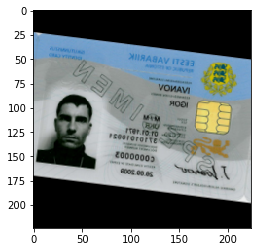

In [157]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [158]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cpu()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([0.35571, 0.64429], dtype=float32)

In [159]:
feat = sf.features[0].data.cpu().numpy()

Big numbers correspond to the cat. So what is this matrix? This matrix simply equals to the value of feature matrix feat times py vector:

In [160]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.25454, 0.01684, 0.11284, 0.24867, 0.14014, 0.04629, 0.22667],
       [0.63303, 0.58469, 0.58603, 0.36602, 0.11548, 0.     , 0.13973],
       [0.49561, 0.51393, 0.88788, 0.43059, 0.39343, 0.17311, 0.44295],
       [0.46016, 0.58755, 0.65822, 0.40493, 0.31842, 0.28016, 0.55935],
       [0.59683, 0.70741, 0.58644, 0.08714, 0.5056 , 0.67962, 0.76826],
       [0.73789, 1.     , 0.55523, 0.45232, 0.98108, 0.72317, 0.67524],
       [0.58713, 0.77194, 0.76514, 0.76719, 0.77206, 0.63376, 0.50454]], dtype=float32)

py vector is the predictions that says “I am 100% confident it’s a cat.” feat is the values (2×7×7) coming out of the final convolutional layer (the Conv2d layer we added). If we multiply feat by py , we get all of the first channel and none of the second channel. Therefore, it is going to return the value of the last convolutional layers for the section which lines up with being a cat. In other words, if we multiply feat by [0, 1] , it will line up with being a dog.



/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


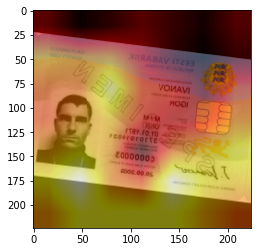

In [161]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

Put it in another way, in the model, the only thing that happened after the convolutional layer was an average pooling layer. The average pooling layer took took the 7 by 7 grid and averaged out how much each part is “cat-like”. We then took the “cattyness” matrix, resized it to be the same size as the original cat image, and overlaid it on top, then you get the heat map.

The way you can use this technique at home is
- when you have a large image, you can calculate this matrix on a quick small little convolutional net
- zoom into the area that has the highest value
- re-run it just on that part